In [1]:
cd ..

c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src


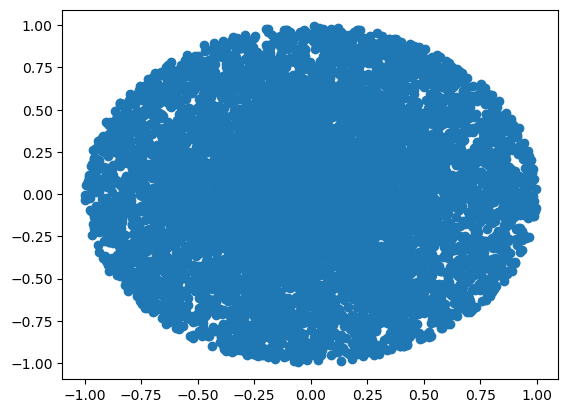

In [2]:
import torch
from torch.autograd.functional import hessian
from torch import nn
from tqdm import tqdm

from domains.starDomain import Sphere
from radialFunctions.radialFunctions import linearRadial
import matplotlib.pyplot as plt

In [3]:
ls

 Volume in Laufwerk C: hat keine Bezeichnung.
 Volumeseriennummer: 7458-2B30

 Verzeichnis von c:\Users\seand\OneDrive\Dokumente\Masterthesis\StarBoundaryNetworks\src

03.10.2024  11:34    <DIR>          .
14.09.2024  22:20    <DIR>          ..
14.09.2024  22:21    <DIR>          config
01.10.2024  14:16    <DIR>          domains
15.09.2024  16:55               139 main.py
03.10.2024  11:34    <DIR>          notebookTests
01.10.2024  18:12    <DIR>          radialFunctions
03.10.2024  11:37             3.561 testFile.py
               2 Datei(en),          3.700 Bytes
               6 Verzeichnis(se), 428.507.164.672 Bytes frei


In [4]:
a = torch.Tensor([[1.,2.],[-1.,0.],[3.,0.]])
a.tile((2,1))

tensor([[ 1.,  2.],
        [-1.,  0.],
        [ 3.,  0.],
        [ 1.,  2.],
        [-1.,  0.],
        [ 3.,  0.]])

# Define Problem

$u_xx(x,y) + u_yy(x,y) = sin(xy)$ on unit sphere

and boundary condition $u(x,y) = x+y$ on sphere

## Define Loss funciton

In [68]:
def laplacian(f, input):
    dim = input.shape[1]
    batchSize = input.shape[0]
    outf = f(input)
    laplacian = torch.zeros(batchSize, dtype=float, requires_grad=True)


    

    dx = torch.autograd.grad(outf, input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0]
    print(dx.isnan().any())
    print("dx shape")
    print(dx.shape)
    for i in range(dim):
        d2x = torch.autograd.grad((dx[:,i]).view(-1,1), input, torch.ones((batchSize, 1), requires_grad=True), create_graph=True)[0][:,i]
        laplacian = laplacian + d2x

    print("laplacian shape") 
    print(laplacian.shape)

    return laplacian.view(-1,1)
    


In [69]:
#define PINN loss function for problem from above:
def pinnLossPoissonSin(u, xy_grid):#, device = 'cuda'):

  laplacian_u = laplacian(u, xy_grid)

  
  return torch.mean( torch.abs(laplacian_u - torch.sin(xy_grid[:,0] * xy_grid[:, 1]).view(-1,1)  )  ), laplacian_u - torch.sin(xy_grid[:,0] * xy_grid[:, 1]).view(-1,1)

In [7]:
grid = torch.arange(10, dtype=float, requires_grad=True).view(-1,2)

In [8]:
grid

tensor([[0., 1.],
        [2., 3.],
        [4., 5.],
        [6., 7.],
        [8., 9.]], dtype=torch.float64, grad_fn=<ViewBackward0>)

In [9]:
def f(grid):
    x1 = grid[:, 0]
    x2 = grid[:, 1]
    return (x1*x1*x2*x2).view(-1,1)

In [10]:
print(f(grid).shape)
laplacian(f, grid)

torch.Size([5, 1])


tensor([[  2.],
        [ 26.],
        [ 82.],
        [170.],
        [290.]], dtype=torch.float64, grad_fn=<ViewBackward0>)

# Define Neural Network with imposed BC

In [19]:
class ImposedBCPINNSphere2D(nn.Module):
  def __init__(self, n_hidden, n_layers):
    super().__init__()
    self.activation_func = nn.Tanh
    self.in_layer = nn.Sequential(*[nn.Linear(2,n_hidden) , self.activation_func()])
    self.hid_layers = nn.Sequential(*[
        nn.Sequential(*[
            nn.Linear(n_hidden, n_hidden),
            nn.Tanh()
            ])
        for i in range(n_layers)], nn.Linear(n_hidden, n_hidden))
    self.out_layer = nn.Linear(n_hidden,1)
    self.domain = Sphere(2, torch.tensor((0.,0.)), torch.tensor(1.))
    self.radialDecayFunciton = linearRadial
  

  def boundaryCondition(self, input):

    return torch.sin(input[:, 0]*input[:, 1])
  
  def boundaryConditionSpherical(self, angles):

    return self.boundaryCondition(self.domain.getCartesianCoordinates( self.domain.radiusDomainFunciton(angles) ,angles))
  
  def zeroOnBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)
    
    return self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)).view(-1,1)
  
  def DCBoundaryExtension(self, input):
    radius, angles = self.domain.getSphericalCoordinates(input)

    return (self.boundaryConditionSpherical( angles) *  (1- self.radialDecayFunciton( radius / self.domain.radiusDomainFunciton(angles)))).view(-1,1)
  
  def forward(self, input):
    x = input + 0
   
    x = self.in_layer(x)
   
    x = self.hid_layers(x)
   
    x = self.out_layer(x)
   

    return x*self.zeroOnBoundaryExtension(input) + self.DCBoundaryExtension(input)

# Train NN

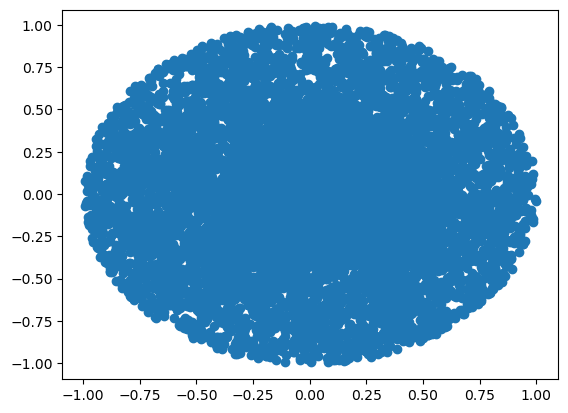

In [90]:
sphereForPoints  = Sphere(2,torch.tensor([0.0,0.0]), 1.)
spherePoints = sphereForPoints.generateRandomPointsFullDomain(10000)

plt.scatter(spherePoints[:,0],spherePoints[:,1])

In [ ]:
#define Trainingset on A:
#num_train_boundary = 16
xy_grid = spherePoints
xy_grid.requires_grad = True
epochs = 100
learningRate  = 1e-2

#model:
solPDE = ImposedBCPINNSphere2D( 16, 4)

optimizer = torch.optim.Adam(solPDE.parameters(), lr = learningRate)


for i in tqdm(range(epochs)):
  optimizer.zero_grad()
 
  loss = pinnLossPoissonSin(solPDE, xy_grid )

  print(loss.item())
  loss.backward(retain_graph=True)
  optimizer.step()


In [91]:
xy_grid = spherePoints
xy_grid.requires_grad = True
epochs = 100
learningRate  = 1e-1
#model:
solPDE = ImposedBCPINNSphere2D( 16, 4)



loss, points = pinnLossPoissonSin(solPDE, xy_grid )

tensor(True)
dx shape
torch.Size([10000, 2])
laplacian shape
torch.Size([10000])


In [92]:
loss

tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>)

In [93]:
points.shape

torch.Size([10000, 1])

In [94]:
torch.argwhere( points.isnan())

tensor([[1021,    0],
        [1830,    0]])

In [96]:
xy_grid[1830].view(-1,2)

tensor([[1.4962e-01, 3.4462e-05]], grad_fn=<ViewBackward0>)

In [87]:
pinnLossPoissonSin(solPDE, xy_grid[6420].view(-1,2) )

tensor(True)
dx shape
torch.Size([1, 2])
laplacian shape
torch.Size([1])


(tensor(nan, dtype=torch.float64, grad_fn=<MeanBackward0>),
 tensor([[nan]], dtype=torch.float64, grad_fn=<SubBackward0>))

In [88]:
solPDE(xy_grid[6420].view(-1,2))

tensor([[-0.0207]], grad_fn=<AddBackward0>)

In [41]:
laplacian_u = laplacian(solPDE, xy_grid)
lossOnGrid = laplacian_u - torch.sin(xy_grid[:,0] * xy_grid[:, 1]).view(-1,1)

In [42]:
lossOnGrid

tensor([[-0.6068],
        [-0.0366],
        [-0.4798],
        ...,
        [-1.0816],
        [ 0.8097],
        [-4.5454]], dtype=torch.float64, grad_fn=<SubBackward0>)

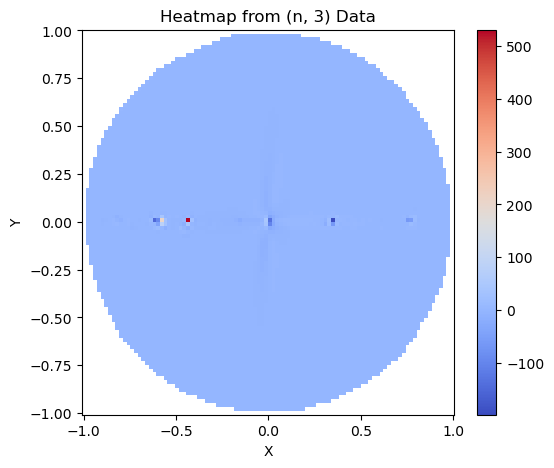

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Assuming your data array is called `data` and has shape (n, 3)
# data[:, 0] = x coordinates
# data[:, 1] = y coordinates
# data[:, 2] = z values to visualize
data = np.empty((xy_grid.shape[0],3))
data[:,0] = xy_grid[:,0].detach().numpy()
data[:,1] = xy_grid[:,1].detach().numpy()
data[:,2] = lossOnGrid.view(-1).detach().numpy()

# Create a meshgrid to interpolate over (choose grid resolution as needed)
grid_x, grid_y = np.mgrid[min(data[:, 0]):max(data[:, 0]):100j, 
                          min(data[:, 1]):max(data[:, 1]):100j]

# Interpolate the z values over the grid
grid_z = griddata((data[:, 0], data[:, 1]), data[:, 2], (grid_x, grid_y), method='cubic')

# Plot the heatmap
plt.figure(figsize=(6, 5))
plt.pcolormesh(grid_x, grid_y, grid_z, cmap='coolwarm', shading='auto')
plt.colorbar()  # Add colorbar to the side
plt.title("Heatmap from (n, 3) Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()
